In [2]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt

from surrojax_gp import create_gp

In [3]:
# Plot settings:
mpl.rcParams['figure.dpi'] = 200

In [4]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

In [5]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def f(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

In [6]:
def plot_function(x, y, z, grid_shape, z_lims=None, train_pts=None, num_levels=1000):
    
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z), num_levels)
    levels = jnp.linspace(z_lims[0], z_lims[1], num_levels)
    
    # Reshape inputs:
    x, y, z = x.reshape(grid_shape), y.reshape(grid_shape), z.reshape(grid_shape)
    
    # Create surface plot:
    fig, ax = plt.subplots()
    contour_fig = ax.contourf(x, y, z, levels=levels, cmap='coolwarm')
    fig.colorbar(contour_fig)
    if train_pts is not None:
        plt.plot(train_pts['x'], train_pts['y'], 'x', color='black', markersize=5)
    fig.patch.set_facecolor('white')
    plt.show()

In [7]:
def create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=None):
    
    # Create list of points:
    x_pts = jnp.linspace(x_lims[0], x_lims[1], x_pts)
    y_pts = jnp.linspace(y_lims[0], y_lims[1], y_pts)
    # Create grid of points:
    y_grid, x_grid = jnp.meshgrid(x_pts, y_pts)
    # Store input:
    
    pts = {'x': x_grid.flatten(), 
           'y': y_grid.flatten(), 
           'input': jnp.stack([x_grid.flatten(), y_grid.flatten()], axis=1)}
    
    # Return z values if requested:
    if true_f is not None:
        pts['z'] = true_f(pts['x'], pts['y'])
    return pts 

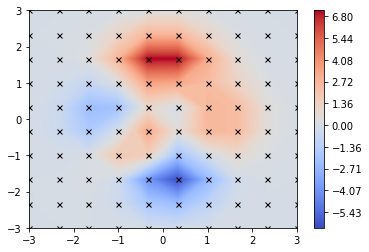

In [8]:
x_lims = y_lims = [-3, 3]
x_pts = y_pts = 10
f_vmap = jax.vmap(f, in_axes=[0,0])
trains_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_vmap)
grid_shape = (y_pts, x_pts)

# Plot training data:
plot_function(trains_pts['x'], trains_pts['y'], trains_pts['z'], grid_shape, train_pts=trains_pts)

# Train GP

In [9]:
# Define constraints:
constraints = {"length_0": {">": 10**-1, "<": 10**1}, 
               "length_1": {">": 10**-1, "<": 10**1}, 
               "const": {">": 10**-1, "<": 10**2}}
# Create GP surrogate:
gp = create_gp(kernel, trains_pts['input'], trains_pts['z'], constraints)

187841.38
144491.56
141478.66
132166.52
139227.27
139144.95
134669.67
132166.52
126250.51
123453.33
118586.42
94383.945
79948.47
63300.652
57167.44
53061.266
266.254
245.47687
213.87555
180.23538
177.26544
172.58325
172.45782
170.42523
171.37238
170.89072
172.01126
171.45798
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
170.42523
      fun: 170.42523193359375
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.11282226, 24.47768402, 43.35464478])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 40
      nit: 15
     njev: 40
   status: 0
  success: True
        x: array([98.80389996,  0.899075  ,  1.22369167])
92243.44
322.2771
322.178
321.75046
319.55896
305.07904
220.66736
28931.45
201.38742
195.7117
183.48615
5744.0776
305.09366
182.69821
177.48885
168.4338
168.81128
167.53262
165.97458
168.82355
165.91023
165.87637
168.19855
165.94983
165.95734
165.87637
168.4263
165.9513

# Regular Predictions

Use GP to make predictions

In [10]:
# Make predictions with GP:
x_lims = y_lims = [-4, 4]
x_pts = y_pts = 20
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_vmap)
# Plot GP surrogate surface and original data surface:
gp_pred = gp.predict(pred_pts['input'])

First compare predictions to training data:

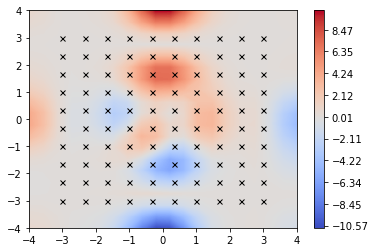

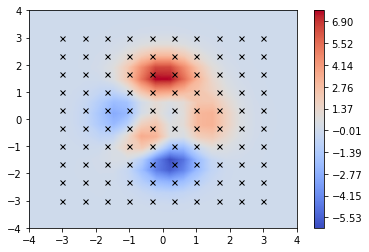

In [11]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['mean'], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], pred_pts['z'], grid_shape, train_pts=trains_pts)

Next, compare variance to difference between plots:

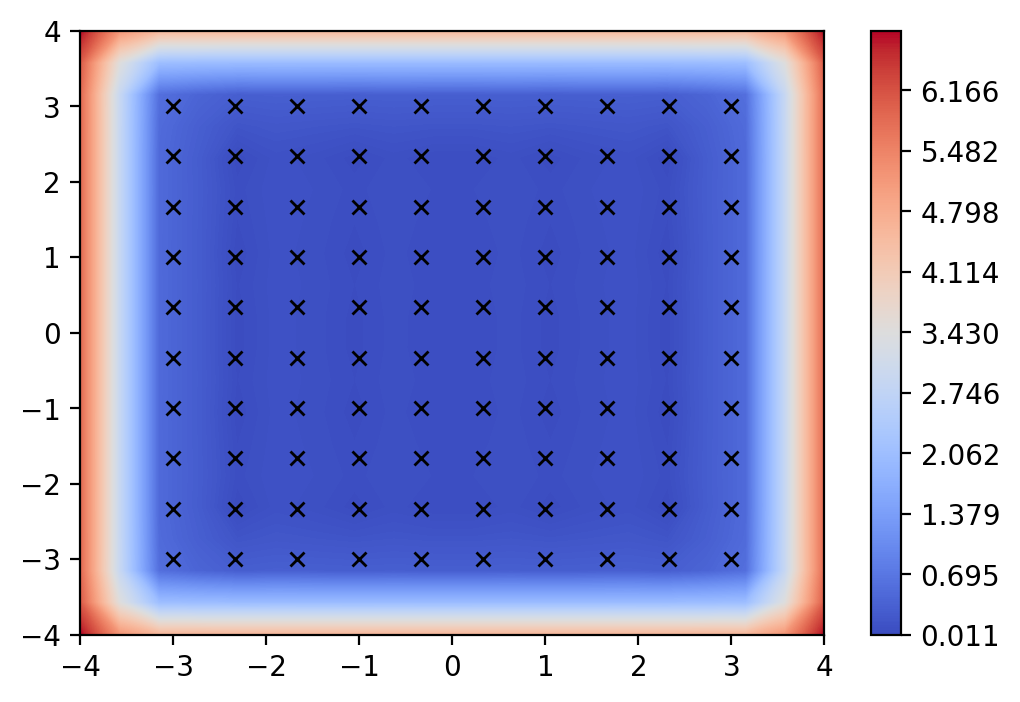

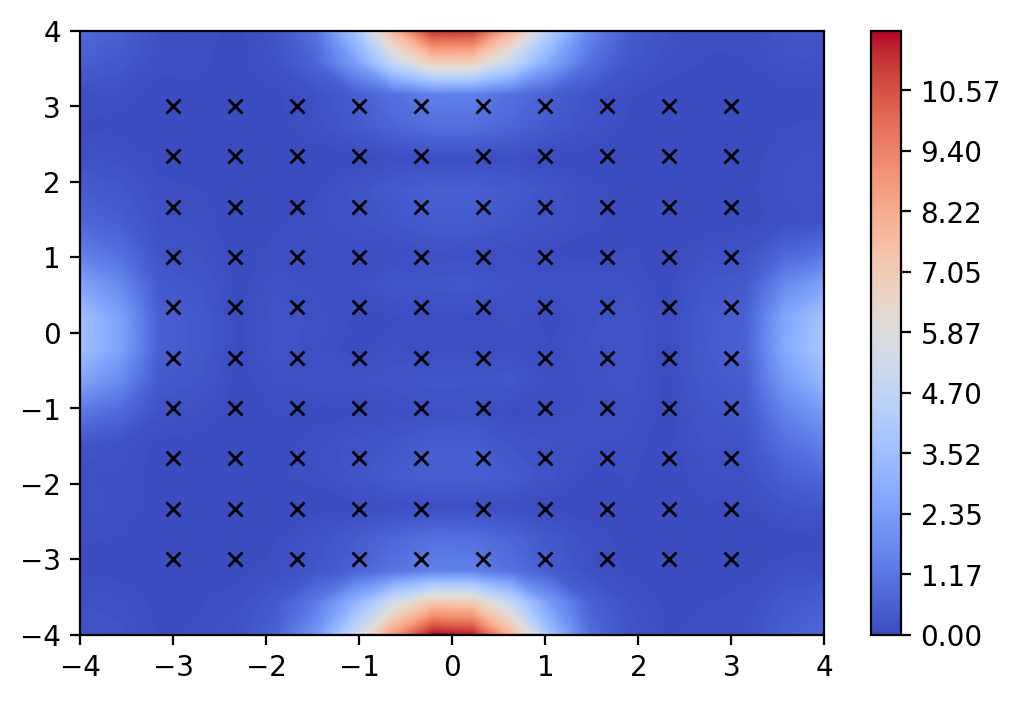

In [11]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['var']**0.5, grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], jnp.abs(gp_pred['mean'] - pred_pts['z']), grid_shape, train_pts=trains_pts)

# Gradient Predictions

First, use GP to predict specified gradient:

In [14]:
# Create 'true' gradient function:
f_grad = jax.jacfwd(jax.jacfwd(f, argnums=0), argnums=1)
f_grad = jax.vmap(f_grad, in_axes=(0,0))

In [15]:
# Make predictions with GP:
x_lims = y_lims = [-4, 4]
x_pts = y_pts = 20
pred_pts = create_pointgrid(x_lims, y_lims, x_pts, y_pts, true_f=f_grad)
# Plot GP surrogate surface and original data surface:
grad = ({'idx': [0], 'order':1}, {'idx': [1], 'order':1})
gp_pred = gp.predict(pred_pts['input'], grad=grad)

Compare predictions to true result:

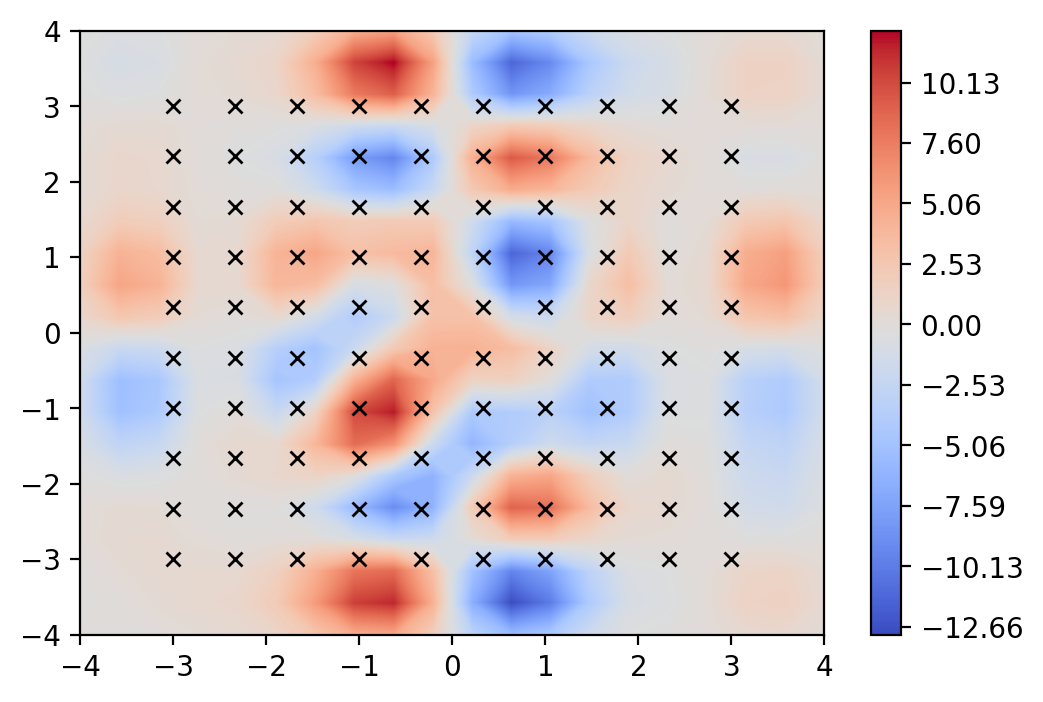

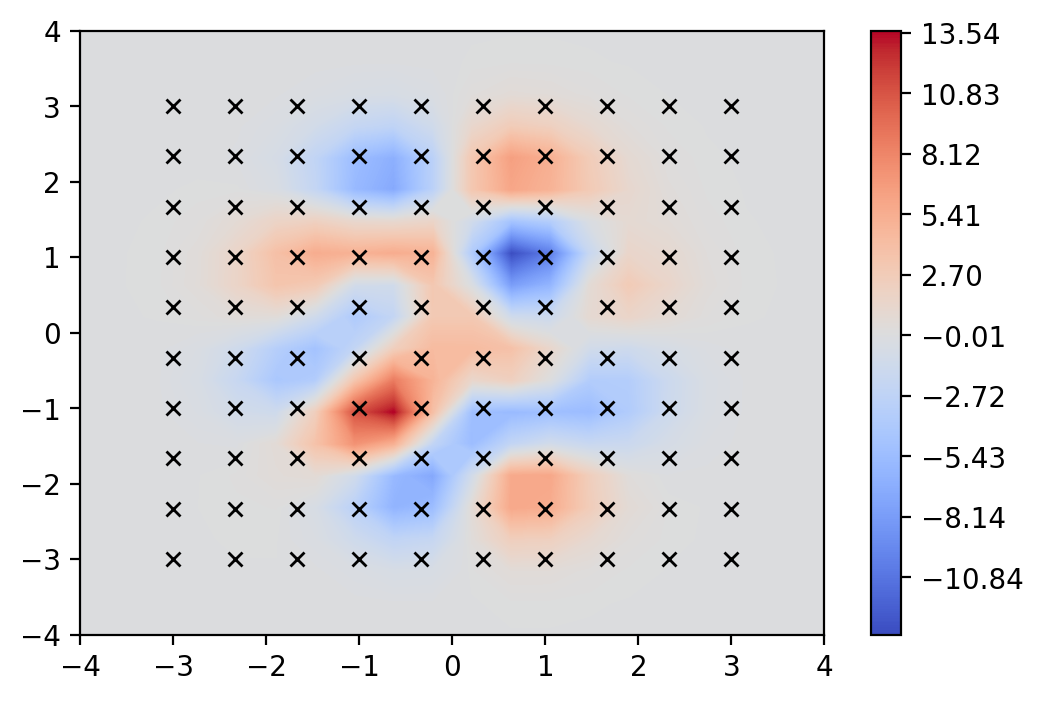

In [16]:
grid_shape = (y_pts, x_pts)
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['mean'][:,0], grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], pred_pts['z'], grid_shape, train_pts=trains_pts)

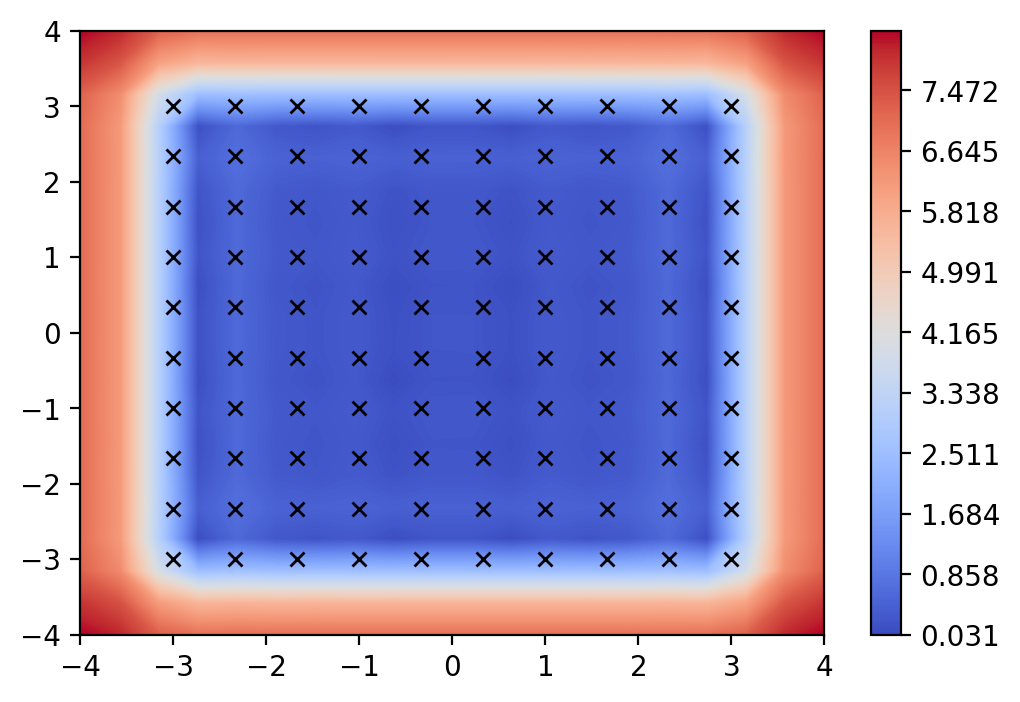

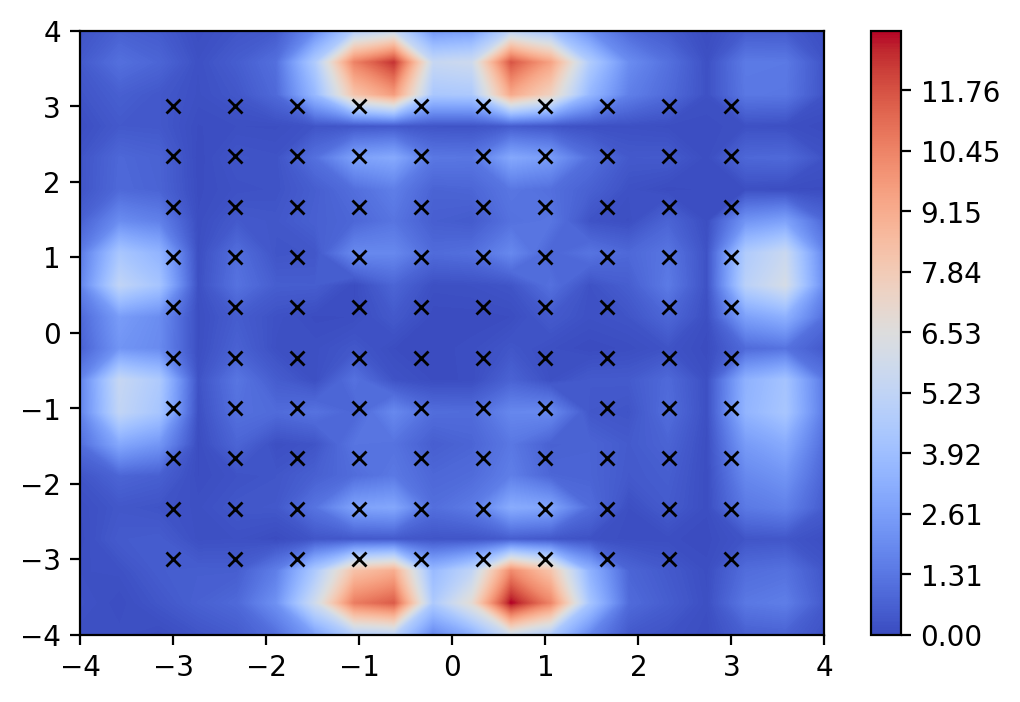

In [17]:
plot_function(pred_pts['x'], pred_pts['y'], gp_pred['var']**0.5, grid_shape, train_pts=trains_pts)
plot_function(pred_pts['x'], pred_pts['y'], jnp.abs(gp_pred['mean'].squeeze() - pred_pts['z'].squeeze()), grid_shape, train_pts=trains_pts)